In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [47]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [48]:
#from keras.callbacks import EarlyS
from keras.callbacks import EarlyStopping

In [49]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [50]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [51]:
import tensorflow as tf
class Config:
    au = "/kaggle/input/casia-dataset/CASIA2/Au"
    tp = "/kaggle/input/casia-dataset/CASIA2/Tp"
    autotune = tf.data.experimental.AUTOTUNE
    epochs = 30
    batch_size = 32
    lr = 1e-3
    name = 'xception'
    n_labels = 2
    image_size = (224, 224)
    decay = 1e-6
    momentum = 0.95
    nesterov = False

In [52]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [53]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

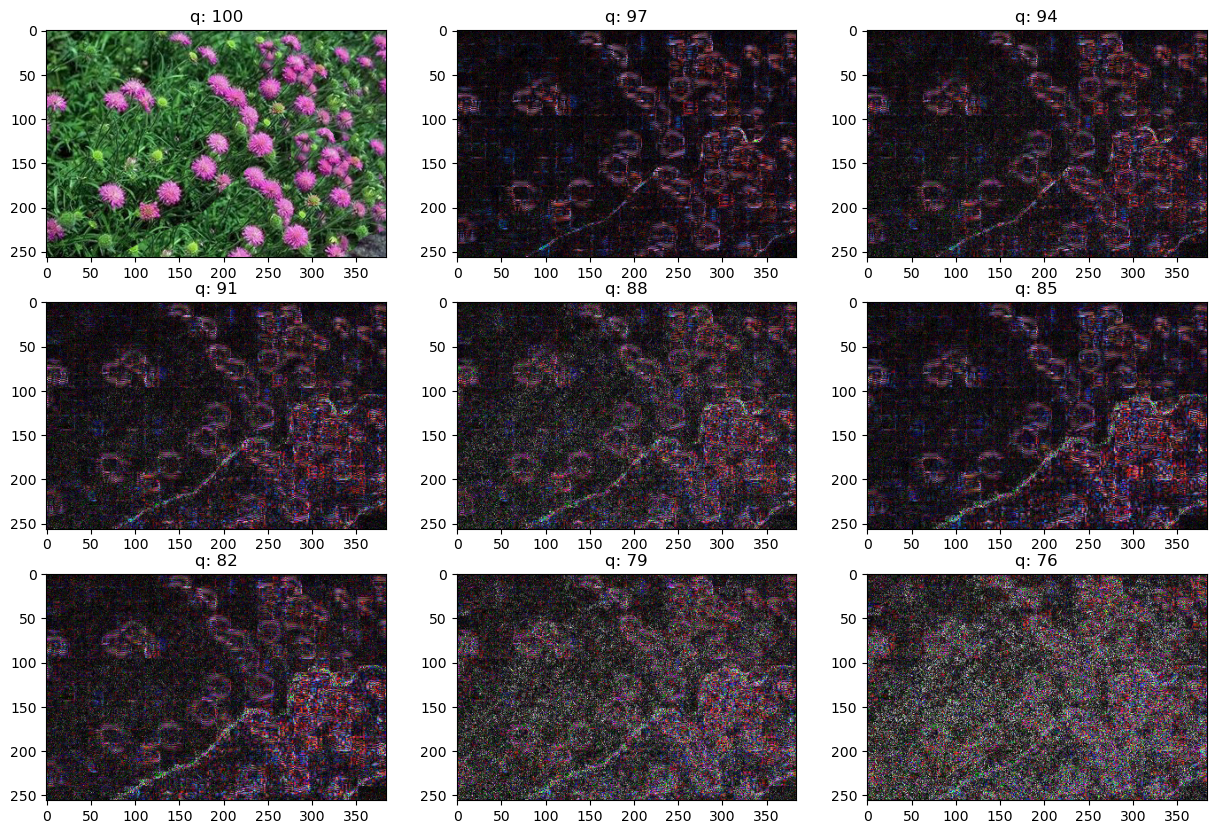

In [54]:
import cv2
from os.path import join, exists, isdir
from pathlib import Path
import random
p = join(Config.tp)
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

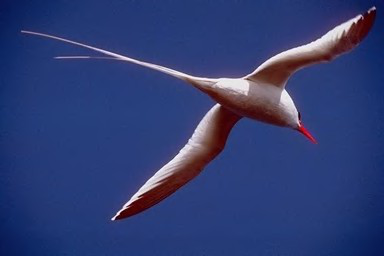

In [55]:
au_image_path = '/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_00005.jpg'
Image.open(au_image_path)

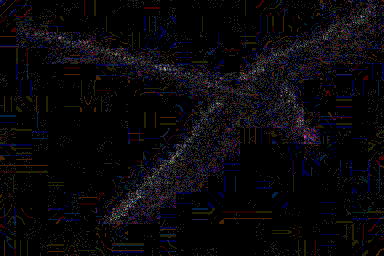

In [56]:
convert_to_ela_image(au_image_path, 91)

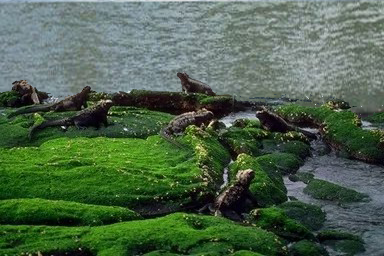

In [57]:
tamp_image_path = '/kaggle/input/casia-dataset/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Image.open(tamp_image_path)

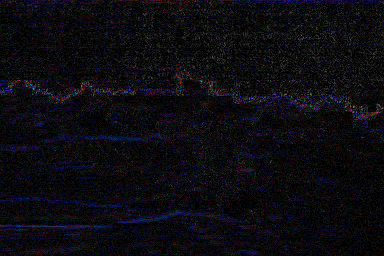

In [58]:
convert_to_ela_image(tamp_image_path, 91)

In [59]:
image_size = (128, 128)

In [60]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 91).resize(image_size)).flatten() / 255.0

In [61]:
X = [] # ELA converted images
Y = [] # 0 for tampered, 1 for real

In [62]:
import random
path = Config.au
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
7354 7354


In [63]:
path = Config.tp
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
Processing 11500 images
Processing 12000 images
12477 12477


In [64]:
import numpy as np
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [65]:
X_t, X_test, Y_t, Y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_t, Y_t, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print("Test images\t\t", len(X_test), len(Y_test))
print("Train images\t\t", len(X_train), len(Y_train))
print("Validation images\t", len(X_val), len(Y_val))

Test images		 1248 1248
Train images		 8983 8983
Validation images	 2246 2246


In [66]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [67]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 115200)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               29491456  
                                                      

In [ ]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_layer_names=False,
expand_nested=True
)

In [68]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [69]:
epochs = 25
batch_size = 32

In [70]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
x_train2 = np.array(X_train, copy=True) 
y_train2 = np.array(Y_train, copy=True) 

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    fill_mode='nearest',
    validation_split = 0.2
    )


# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)

datagen.fit(X_train)

print(type(X_train))

#earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')

validation_generator = datagen.flow(x_train2, y_train2, batch_size=32, subset='validation')
train_generator = datagen.flow(x_train2, y_train2,batch_size=32, subset='training')


# # fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_generator, epochs=epochs, validation_data = (X_val,Y_val), verbose = 1,callbacks = [early_stopping])

In [71]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [72]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val))

Epoch 1/25


2024-04-04 13:23:37.979428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


281/281 [==============================] - 20s 45ms/step - loss: 0.3857 - accuracy: 0.8256 - val_loss: 0.3315 - val_accuracy: 0.8816
Epoch 2/25
281/281 [==============================] - 11s 41ms/step - loss: 0.2933 - accuracy: 0.8951 - val_loss: 0.4009 - val_accuracy: 0.8357
Epoch 3/25
281/281 [==============================] - 11s 41ms/step - loss: 0.2697 - accuracy: 0.8983 - val_loss: 0.3288 - val_accuracy: 0.8638
Epoch 4/25
281/281 [==============================] - 11s 41ms/step - loss: 0.2350 - accuracy: 0.9124 - val_loss: 0.2501 - val_accuracy: 0.8998
Epoch 5/25
281/281 [==============================] - 12s 41ms/step - loss: 0.2170 - accuracy: 0.9146 - val_loss: 0.2448 - val_accuracy: 0.9020
Epoch 6/25
281/281 [==============================] - 12s 41ms/step - loss: 0.2061 - accuracy: 0.9164 - val_loss: 0.2269 - val_accuracy: 0.9056
Epoch 7/25
281/281 [==============================] - 12s 41ms/step - loss: 0.1903 - accuracy: 0.9210 - val_loss: 0.2338 - val_accuracy: 0.9047
Epo

In [ ]:
model.save('model_casia_run1.h5')

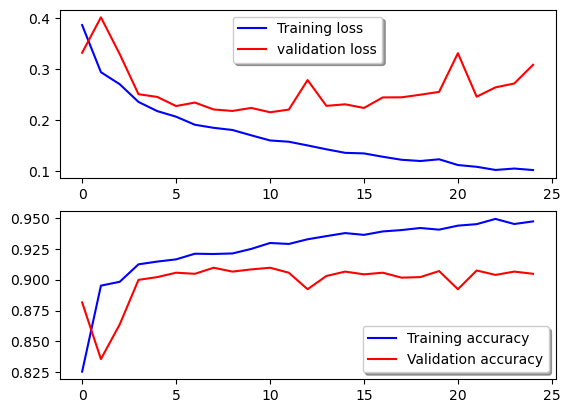

In [73]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

71/71 [==============================] - 1s 9ms/step


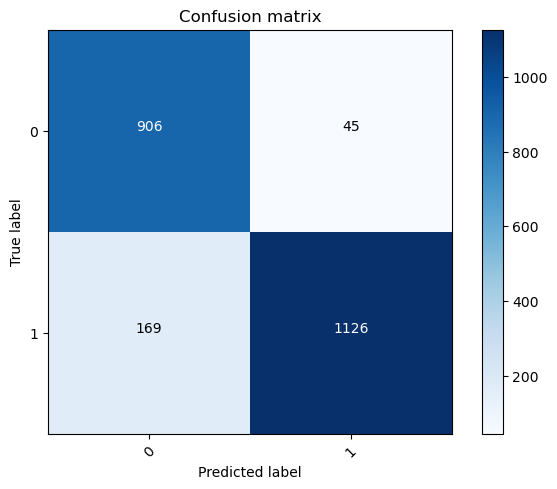

In [77]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [78]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Compute accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(Y_true, Y_pred_classes)
print("Precision:", precision)
print("-----------------------------------------------------")


# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes))


Accuracy: 0.9047195013357079
Precision: 0.9615713065755764
-----------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       951
           1       0.96      0.87      0.91      1295

    accuracy                           0.90      2246
   macro avg       0.90      0.91      0.90      2246
weighted avg       0.91      0.90      0.91      2246



39/39 [==============================] - 0s 9ms/step


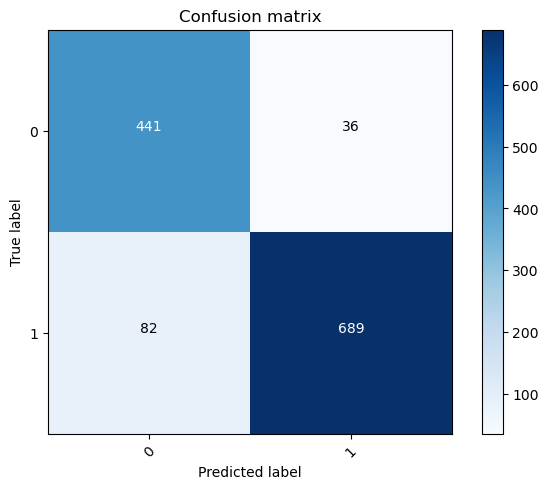

In [79]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [80]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Compute accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(Y_true, Y_pred_classes)
print("Precision:", precision)
print("-----------------------------------------------------")


# Classification Report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes))


Accuracy: 0.905448717948718
Precision: 0.9503448275862069
-----------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       477
           1       0.95      0.89      0.92       771

    accuracy                           0.91      1248
   macro avg       0.90      0.91      0.90      1248
weighted avg       0.91      0.91      0.91      1248



In [81]:
class_names = ['tampered', 'real']

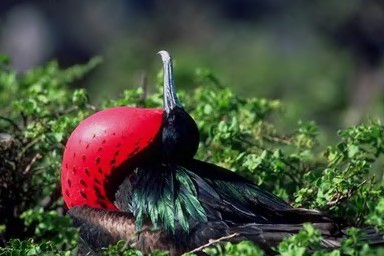

In [91]:
real_image_path = '/kaggle/input/casia-dataset/CASIA2/Au/Au_ani_00004.jpg'
Image.open(real_image_path)

In [92]:
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 22ms/step
Class: real Confidence: 100.00


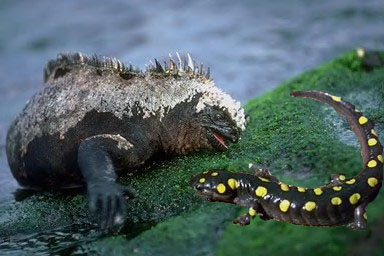

In [89]:
tamp_image_path = '/kaggle/input/casia-dataset/CASIA2/Tp/Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg'
Image.open(tamp_image_path)

In [90]:
image = prepare_image(
    tamp_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 22ms/step
Class: tampered Confidence: 100.00


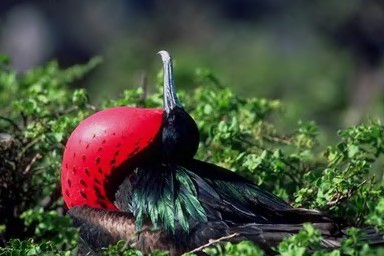

In [93]:
image_path1 = real_image_path
Image.open(image_path1)

In [94]:
image = prepare_image(image_path1)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 22ms/step
Class: real Confidence: 100.00


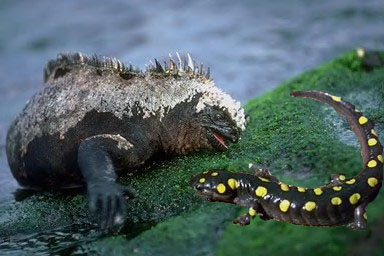

In [96]:
image_path2 = tamp_image_path
Image.open(image_path2)

In [97]:
image = prepare_image(image_path2)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 24ms/step
Class: tampered Confidence: 100.00


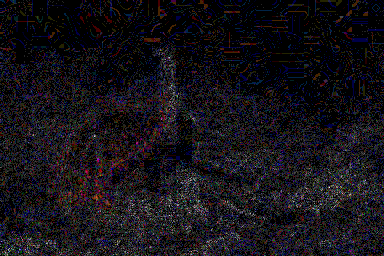

In [98]:
convert_to_ela_image(image_path1, 91)

In [99]:
image_1_ELA=convert_to_ela_image(image_path1, 91)

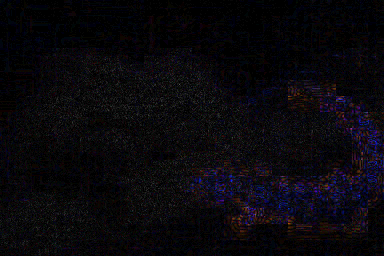

In [100]:
convert_to_ela_image(image_path2, 91)

In [101]:
image_2_ELA=convert_to_ela_image(image_path2, 91)

In [102]:
ela_image = ImageChops.difference(image_1_ELA, image_2_ELA)

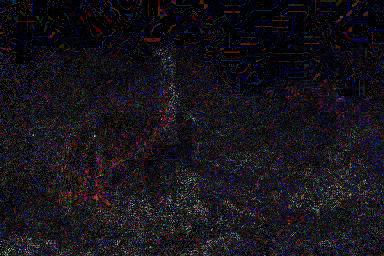

In [103]:
ela_image

In [104]:
print(y_pred_class)

0


In [105]:
def find_manipulated_region(ela, threshold=50):
    mask = np.array(ela) > threshold

    # Find the bounding box of the masked region
    if np.any(mask):
        coords = np.argwhere(mask)
        return coords
    else:
        return None

In [106]:
def make_pixels_white(img, white_coords):
    width, height = img.size
    black_img = Image.new('RGB', (width, height), color='black')
    img_arr = np.array(img)
    black_arr = np.array(black_img)
    for coord in white_coords:
        x, y, z = coord
        black_arr[x,y,:] = [255,255,255]
    mask = np.all(black_arr == [255,255,255], axis=-1)
    img_arr[mask] = [255,255,255]
    new_img = Image.fromarray(img_arr)
    return new_img

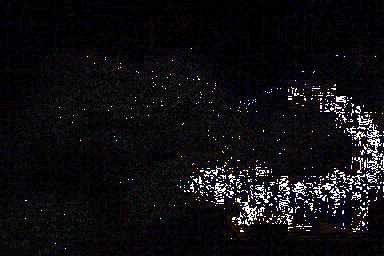

In [108]:
if y_pred_class==0:
    ela=convert_to_ela_image(image_path2,91)
    coords=find_manipulated_region(ela)
    modify_boundary=make_pixels_white(ela,coords)
    display(modify_boundary)